In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
from torch import Tensor
import os

import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
inputs = torch.load("data/inputs.pt")
inputs.shape

torch.Size([1, 2, 512, 512])

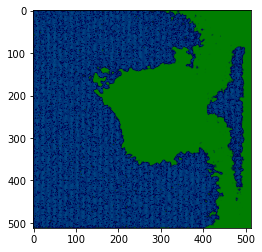

[[0.3254554  0.45405948 0.3256599  ... 0.32642955 0.32603687 0.3265348 ]
 [0.32618737 0.68241584 0.32552135 ... 0.32602516 0.3258852  0.3264545 ]
 [0.32562023 0.7087712  0.32545555 ... 0.32601902 0.32600656 0.32625362]
 ...
 [0.3257541  0.9683681  0.3265444  ... 0.32601276 0.3262869  0.32638985]
 [0.3258061  0.6962601  0.32654738 ... 0.32594562 0.32594585 0.32616737]
 [0.32618585 0.67901945 0.32626995 ... 0.3260348  0.32597527 0.32625735]]


In [10]:
plt.imshow(inputs.cpu().detach().numpy()[0, 0, :, :] * 255, cmap="ocean")
plt.show()
print(inputs.cpu().detach().numpy()[0, 0, :, :])

In [ ]:
class NCutLoss2D(nn.Module):
    r"""Implementation of the continuous N-Cut loss, as in:
    'W-Net: A Deep Model for Fully Unsupervised Image Segmentation', by Xia, Kulis (2017)"""

    def __init__(self, radius: int = 4, sigma_1: float = 5, sigma_2: float = 1):
        r"""
        :param radius: Radius of the spatial interaction term
        :param sigma_1: Standard deviation of the spatial Gaussian interaction
        :param sigma_2: Standard deviation of the pixel value Gaussian interaction
        """
        super(NCutLoss2D, self).__init__()
        self.radius = radius
        self.sigma_1 = sigma_1  # Spatial standard deviation
        self.sigma_2 = sigma_2  # Pixel value standard deviation

    def forward(self, inputs: Tensor, labels: Tensor) -> Tensor:
        r"""Computes the continuous N-Cut loss, given a set of class probabilities (labels) and raw images (inputs).
        Small modifications have been made here for efficiency -- specifically, we compute the pixel-wise weights
        relative to the class-wide average, rather than for every individual pixel.
        :param labels: Predicted class probabilities
        :param inputs: Raw images
        :return: Continuous N-Cut loss
        """
        num_classes = labels.shape[1]
        kernel = gaussian_kernel(radius=self.radius, sigma=self.sigma_1, device=labels.device.type)
        loss = 0

        for k in range(num_classes):
            # Compute the average pixel value for this class, and the difference from each pixel
            class_probs = labels[:, k].unsqueeze(1)
            class_mean = torch.mean(inputs * class_probs, dim=(2, 3), keepdim=True) / \
                         torch.add(torch.mean(class_probs, dim=(2, 3), keepdim=True), 1e-5)
            diff = (inputs - class_mean).pow(2).sum(dim=1).unsqueeze(1)

            # Weight the loss by the difference from the class average.
            weights = torch.exp(diff.pow(2).mul(-1 / self.sigma_2 ** 2))

            # Compute N-cut loss, using the computed weights matrix, and a Gaussian spatial filter
            numerator = torch.sum(class_probs * F.conv2d(class_probs * weights, kernel, padding=self.radius))
            denominator = torch.sum(class_probs * F.conv2d(weights, kernel, padding=self.radius))
            loss += nn.L1Loss()(numerator / torch.add(denominator, 1e-6), torch.zeros_like(numerator))

        return num_classes - loss

In [39]:
def generate_distance_tensor(r):
    region = torch.zeros((2*r+1, 2*r+1))
    for x in range(region.shape[0]):
        for y in range(region.shape[1]):
            region[x, y] = -get_distance_sq(np.array([x, y]), np.array([r, r]))
    return torch.exp(region/SIGMA_X2)

def get_distance_sq(p1, p2):
    dif = p1 - p2
    return np.dot(dif.T, dif)

RADIUS = 1
REGION_SIZE = 2*[2*RADIUS+1]
SIGMA_X2 = 4
image = torch.round(torch.ones(3,3) * 255)



regions = torch.nn.Unflatten(1, REGION_SIZE)(torch.nn.Unfold(REGION_SIZE, padding=RADIUS)(
    image[(None,) * 2])).permute(0, 3, 1, 2)

i_f = image.flatten()[None, :, None, None]

d = generate_distance_tensor(1)
d

tensor([[0.6065, 0.7788, 0.6065],
        [0.7788, 1.0000, 0.7788],
        [0.6065, 0.7788, 0.6065]])

In [2]:
print("Loading tensors...", end=" ")
print("DONE!",)

Loading tensors... DONE!
